## Training the model

The CNN architecture that I am gonna be using for training the model here in this notebook is saved in models.py file that I will import here, or anywhere it's required. 

#### Why models.py ?

I have been taught this good practice that for most of the projects you can write your Neural Network architecture in `models.py` file so that any models I define can be saved and loaded by name in different notebooks in the project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# loading the data
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

#the output of the cell is gonna be very long, so you can scroll directly to the end of the page then scroll up.

mkdir: cannot create directory ‘/data’: File exists
--2020-05-13 13:50:33--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.36.142
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.36.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘/data/train-test-data.zip’

train-test-data.zip 100%[===================>] 322.93M  96.1MB/s    in 3.5s    

2020-05-13 13:50:37 (91.0 MB/s) - ‘/data/train-test-data.zip’ saved [338613624/338613624]

Archive:  /data/train-test-data.zip
   creating: /data/test/
  inflating: /data/test/Abdel_Aziz_Al-Hakim_00.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_01.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_10.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_11.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_40.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Ha

In [2]:
# import the usual resources
import torch
import matplotlib.pyplot as plt
import numpy as np
# check if CUDA is available
use_cuda = torch.cuda.is_available()

# import utilities to keep workspaces alive during model training
from workspace_utils import active_session

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#instantiating the model from models.py
from models import Net

net = Net()
print(net)

#move to GPU if available
if use_cuda:
    net.cuda()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=2000, bias=True)
  (fc2): Linear(in_features=2000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=136, bias=True)
  (dropout1): Dropout(p=0.1)
  (dropout2): Dropout(p=0.2)
  (dropout3): Dropout(p=0.3)
  (dropout4): Dropout(p=0.4)
)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.
These transformations have been defined in `data_load.py`.

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from data_load import FacialKeypointsDataset
from data_load import Rescale, RandomCrop, Normalize, ToTensor

data_transform = transforms.Compose([Rescale(240),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

assert(data_transform is not None), 'Define a data_transform'

In [5]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


## Batching and loading data

In [6]:
# load training data in batches
batch_size = 128

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [7]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform)



In [8]:
# load test data in batches
batch_size = 128

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points, we have to "un-transform" the image/keypoint data to display it.

I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [11]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

`visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform.

In [13]:
# visualize the output
# I have set this to show only 10 outputs
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)
        test_images = test_images.cpu()
        test_outputs = test_outputs.cpu()
        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()


## Training

In [13]:
import torch.optim as optim

criterion = torch.nn.SmoothL1Loss()

optimizer = optim.Adam(net.parameters(), lr=0.001)


In [14]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']
            
            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)
            
            if use_cuda:
                images, key_pts = images.cuda(), key_pts.cuda()

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = torch.sqrt(criterion(output_pts, key_pts))

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0

    print('Finished Training')


In [15]:
# train network
n_epochs = 100

with active_session():
    train_net(n_epochs)

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 10, Avg. Loss: 0.6189435720443726
Epoch: 1, Batch: 20, Avg. Loss: 0.4420516431331635
Epoch: 2, Batch: 10, Avg. Loss: 0.29841542840003965
Epoch: 2, Batch: 20, Avg. Loss: 0.27847875356674195
Epoch: 3, Batch: 10, Avg. Loss: 0.27933852672576903
Epoch: 3, Batch: 20, Avg. Loss: 0.2766501665115356
Epoch: 4, Batch: 10, Avg. Loss: 0.28088525533676145
Epoch: 4, Batch: 20, Avg. Loss: 0.2713077560067177
Epoch: 5, Batch: 10, Avg. Loss: 0.2739341765642166
Epoch: 5, Batch: 20, Avg. Loss: 0.27186804413795473
Epoch: 6, Batch: 10, Avg. Loss: 0.27126605063676834
Epoch: 6, Batch: 20, Avg. Loss: 0.2653724417090416
Epoch: 7, Batch: 10, Avg. Loss: 0.2702148735523224
Epoch: 7, Batch: 20, Avg. Loss: 0.27224250733852384
Epoch: 8, Batch: 10, Avg. Loss: 0.274235212802887
Epoch: 8, Batch: 20, Avg. Loss: 0.27324173897504805
Epoch: 9, Batch: 10, Avg. Loss: 0.25887638330459595
Epoch: 9, Batch: 20, Avg. Loss: 0.27259342521429064
Epoch: 10, Batch: 10, Avg. Loss: 0.2768922299146652
Epoch: 10, Batch: 20,

## Test data

In [15]:
# test the model on a batch of test images 
# function to extract a test sample

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)
        
        if use_cuda:
                images, key_pts = images.cuda(), key_pts.cuda()

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

In [16]:
# get a sample of test data
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([128, 1, 224, 224])
torch.Size([128, 68, 2])
torch.Size([128, 68, 2])


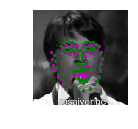

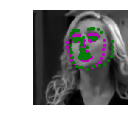

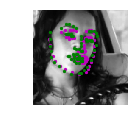

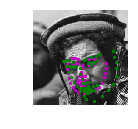

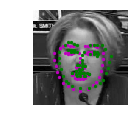

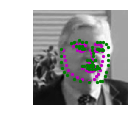

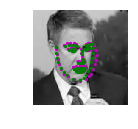

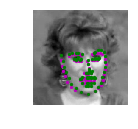

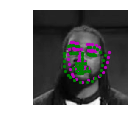

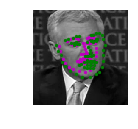

In [17]:
visualize_output(test_images, test_outputs, gt_pts)


In [18]:
# save model
model_dir = 'saved_models/'
model_name = 'keypoints_model_1.pt'

torch.save(net.state_dict(), model_dir+model_name)

## Feature Visualization

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[ 0.14795384 -0.12784955  0.25300175  0.20602921 -0.07494157]
 [-0.06281316  0.2249728   0.12335959  0.07569068  0.09757778]
 [-0.13440916  0.03242321  0.13428009 -0.02102039 -0.07204004]
 [ 0.1179764  -0.10290004 -0.17937526 -0.24274522  0.15383279]
 [-0.03617718 -0.13041027 -0.03506539 -0.24086389 -0.19910464]]
(5, 5)


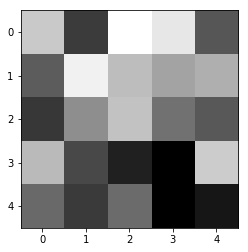

In [19]:
#transfer model to cpu
net = net.cpu()

# Get the weights in the first conv layer, "conv1"
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 10

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps: Filter an image to see the effect of a convolutional kernel
---

Text(0.5,1,'filtered image')

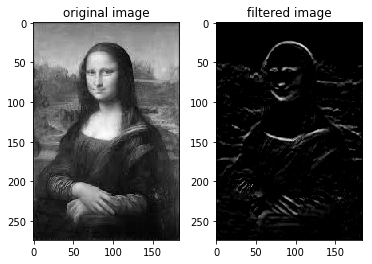

In [20]:
# load in and display any image from the transformed test dataset
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

some_image = mpimg.imread('images/mona_lisa.jpg')
some_img_copy = some_image.copy()
some_img_gray = cv2.cvtColor(some_img_copy, cv2.COLOR_RGB2GRAY)

# Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image
feature_map = cv2.filter2D(some_img_gray, -1, w[10][0])

f, ax = plt.subplots(1, 2)
ax[0].imshow(some_img_gray, cmap='gray')
ax[0].set_title('original image')
ax[1].imshow(feature_map, cmap='gray')
ax[1].set_title('filtered image')